<a href="https://colab.research.google.com/github/AhmadAtwi10/coursera-test2/blob/main/pytorch_mnist_GAN_student(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


In [28]:
!nvidia-smi

Tue Dec 12 16:29:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    26W /  70W |    681MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Data Loading
We provide the code for data loading.

In [30]:
bs = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Specify the generator and the discriminator to get the following architectures:

```
 Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
```


```
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)
```

We recommend the use of leaky-relu for the hidden layers and tanh for the last layer of the generator. We recommend to use 0.2 as parameter for the leaky-relu activations. We let you chose the appropriate activation for the last layer of the discriminator. We also recommend using dropout(0.3) in the discriminator.


In [31]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim,g_output_dim,bias=True)
        self.fc2 = nn.Linear(g_input_dim,g_output_dim,bias=True)
        self.fc3 = nn.Linear(g_input_dim,g_output_dim,bias=True)
        self.fc4 = nn.Linear(g_input_dim,g_output_dim,bias=True)

    # forward method
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x),0.2)
        h = F.leaky_relu(self.fc1(x),0.2)
        h = F.leaky_relu(self.fc1(x),0.2)
        return F.tanh(self.fc4(x))

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)  # Introduce dropout with a probability of 0.5

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.2)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

## We instantiate the networks

In [32]:
# build network
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
D = Discriminator(d_input_dim=mnist_dim).to(device)


You can check if the architectures are correct.

In [33]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=784, bias=True)
  (fc2): Linear(in_features=100, out_features=784, bias=True)
  (fc3): Linear(in_features=100, out_features=784, bias=True)
  (fc4): Linear(in_features=100, out_features=784, bias=True)
)

In [34]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Training configuration
Chose the discriminator loss.

In [35]:
# loss
criterion = nn.BCEWithLogitsLoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


Now, let's code the discriminator update

In [37]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # Train discriminator on real
    x_real = x.view(-1, mnist_dim)
    y_real = torch.ones(x.size(0), 1).to(device)  # Real labels are 1
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output_real = D(x_real)
    D_real_loss = criterion(D_output_real, y_real)

    # Train discriminator on fake
    z = Variable(torch.randn(x.size(0), z_dim).to(device))
    x_fake = G(z)
    y_fake = torch.zeros(x.size(0), 1).to(device)  # Fake labels are 0
    D_output_fake = D(x_fake.detach())  # Detach to avoid backpropagating through the generator
    D_fake_loss = criterion(D_output_fake, y_fake)

    # Total discriminator loss
    D_loss = D_real_loss + D_fake_loss

    # Gradient backpropagation and optimization for discriminator
    D_loss.backward()
    D_optimizer.step()

    return D_loss.item()


Now, let's code the generator update

In [38]:
def G_train():
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = torch.ones(bs, 1).to(device)  # Generator wants to fool the discriminator, so the labels are set to 1

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backpropagation and optimization for generator
    G_loss.backward()
    G_optimizer.step()

    return G_loss.item()


We provide this visualization function.

In [39]:
# Plot the loss from each batch
def plotLoss(epoch, d_losses, g_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminative loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, generated_images, dim=(10, 10), figsize=(10, 10)):
    generated_images = generated_images.cpu().numpy()
    print(generated_images.shape)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generated_images[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


Finally, this is the main loop:

[1/20]: loss_d: 0.051, loss_g: 6.742
(100, 1, 28, 28)


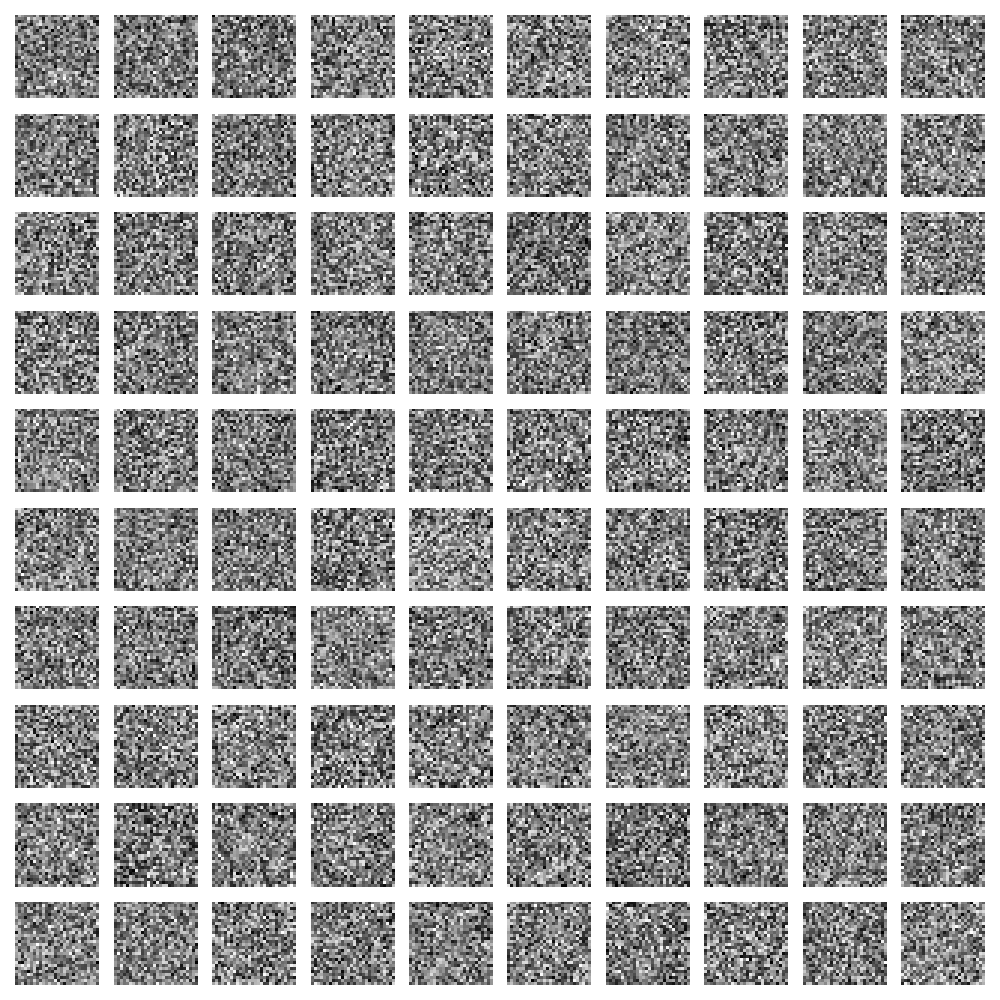

[2/20]: loss_d: 0.005, loss_g: 10.414
(100, 1, 28, 28)


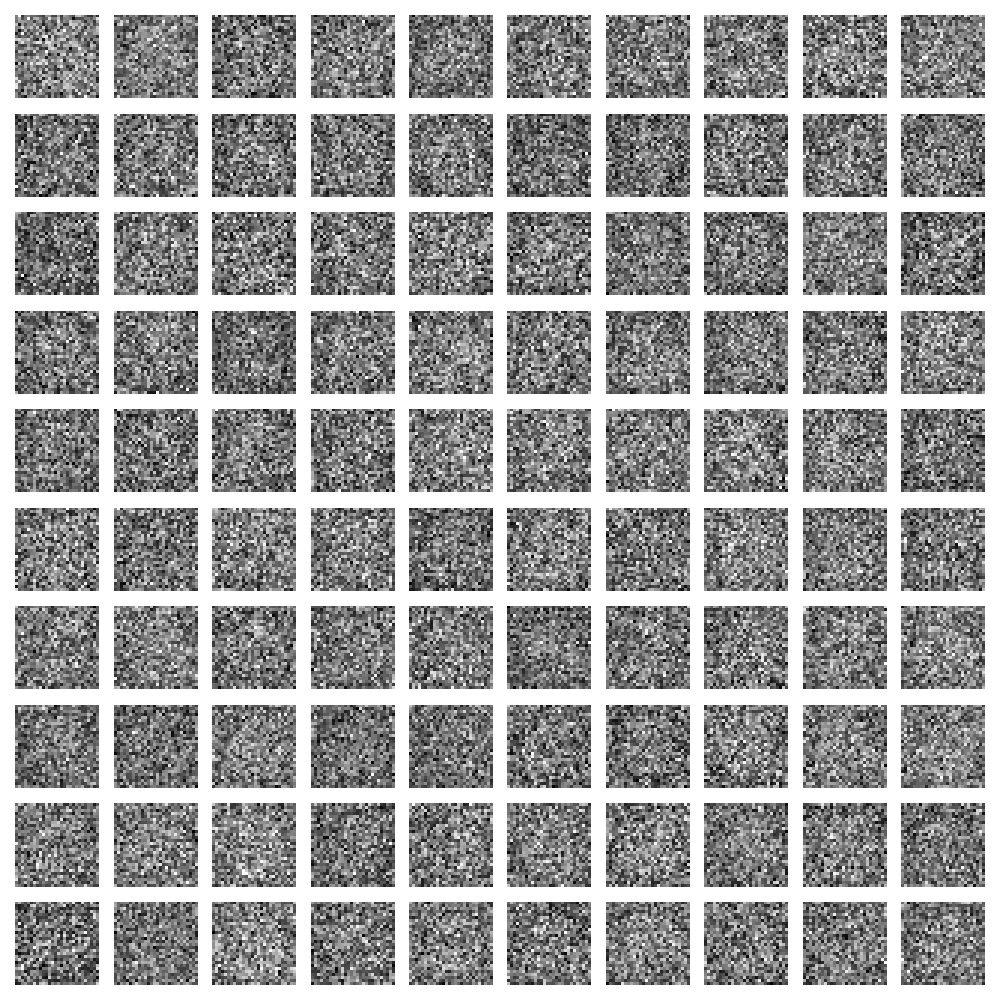

[3/20]: loss_d: 0.004, loss_g: 12.952
(100, 1, 28, 28)


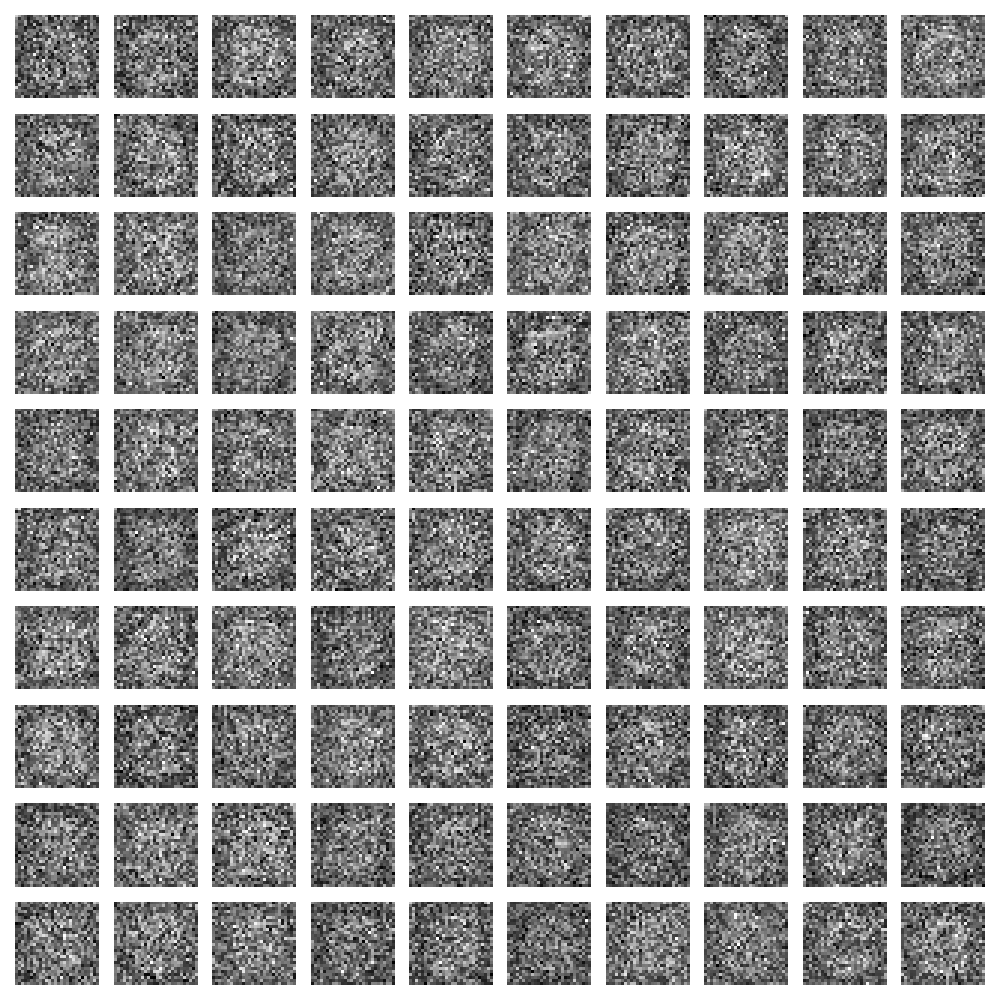

[4/20]: loss_d: 0.007, loss_g: 13.561
(100, 1, 28, 28)


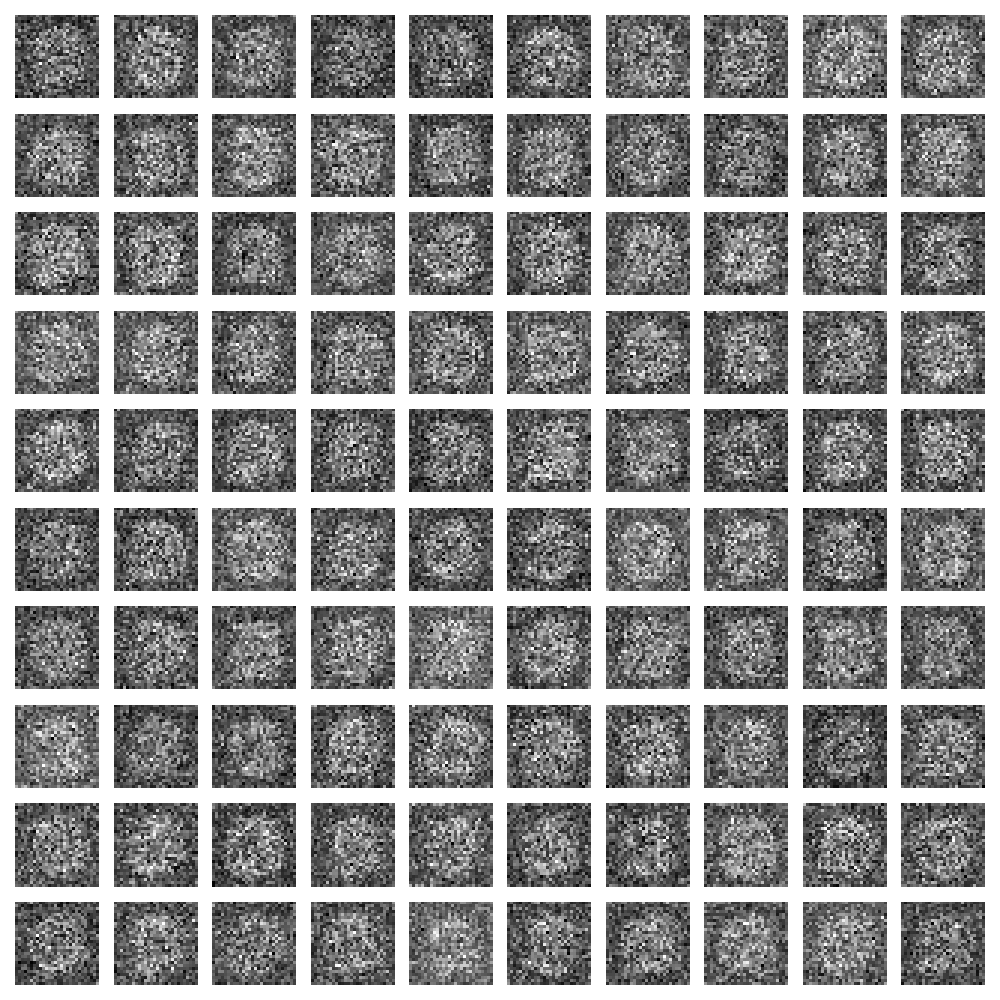

In [ ]:
n_epoch = 20

for epoch in range(1, n_epoch + 1):
    D_losses, G_losses = [], []

    for batch_idx, (x, _) in enumerate(train_loader):
        # Training the discriminator
        loss_D = D_train(x)
        D_losses.append(loss_D)

        # Training the generator
        loss_G = G_train()
        G_losses.append(loss_G)

    # Print and plot the losses
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        epoch, n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

    # Plot generated images
    with torch.no_grad():
        test_z = Variable(torch.randn(bs, z_dim).to(device))
        generated = G(test_z)
        plotGeneratedImages(epoch, generated.view(generated.size(0), 1, 28, 28))

    # Plot and save the losses
    plotLoss(epoch, D_losses, G_losses)


DCGAN

Save a copy of your colab. Now, we will implement a version of GAN that uses convolutions: DCGAN. You can find the paper [here](https://arxiv.org/abs/1511.06434). The main idea of DCGAN is to use convolutions in the generator and discriminator in order to get images that are more spacially consistent. Replace your naive generator and decoder by the DCGAN architectures. This is slower to train but by looking at the images after one epoch, you can already draw an interesting conclusion. The architecture is not clearly specified for mnist. You can use the following generator (use leakyRelu):


*   Dense(128x7x7)
*   UpSampling2D
*   Conv2D(64, kernel_size=(5, 5)
*   UpSampling2D
*   Conv2D(1, kernel_size=(5, 5)

Use a tanh activation at the end.

For the discriminator:


* Conv2D(64, kernel_size=(5, 5), strides=(2, 2)
* Conv2D(128, kernel_size=(5, 5), strides=(2, 2)
* Dense(1, activation='sigmoid'))
